## Multimodal Training Baseline

Pipeline for loading and preprocessing data, training model and evaluating

In [1]:
import os
import torch
import pickle
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_ # modifies the tensors in-place (vs clip_grad_norm)
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import sys
sys.path.append('./BGR')
import bgr.soil.datasets as bgr_data
import bgr.soil.models as bgr_mod
from bgr.soil.callbacks import EarlyStopping
from bgr.soil.metrics import top_k_accuracy, TopKLoss

In [3]:
path_csv = "../data/BGR/data_horizons.csv"
path_csv_annotator_ids = '../data/BGR/Kartierer_ID.csv'
path_csv_locations = '../data/BGR/STANDORT.csv'
path_horizons_simple = '../data/BGR/Vereinfachung_Horizontsymbole.csv'
path_pictures = "../data/BGR/Profilbilder_no_ruler_no_sky/"
#path_pictures = "../data/BGR/Horizonte/"

### Data Loading

In [4]:
df = pd.read_csv(path_csv)
print(len(df.index))
df = df.dropna(subset=['Horizontsymbol'])
print(len(df.index))
df#.head()

15207
15206


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_simple = pd.read_csv(path_horizons_simple)
df_simple.rename(columns={"relevanter Anteil = was sinntragend und detektierbar ist - es sind nicht alles gültige Symbole": "relevanter Anteil"}, inplace=True)
df_simple.head()

,Horiz,Anzahl im Datensatz,relevanter Anteil,stark vereinfacht
0,Ap,1762,Ap,Ap
1,Bv,626,Bv,Bv
2,ilCv,620,ilC,Cv
3,elCv,500,elC,Cv
4,Ah,455,Ah,Ah


In [6]:
# Add an extra column to the original dataset with the simplified horizon symbols

# Apply the simplification function to each row of the 'Horizontsymbol' column
col_name = "relevanter Anteil" # try to predict 'relevanter Anteil' first; otherwise, resort to 'stark vereinfacht'
df['Horizontsymbol_relevant'] = df['Horizontsymbol'].apply(lambda x: bgr_data.simplify_string(x, df_simple, col_name))

# Reorder the columns
cols = df.columns.tolist()
cols.insert(cols.index('Horizontsymbol') + 1, 'Horizontsymbol_relevant')
cols.pop() # remove the duplicate at the end
df = df[cols]
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


#### Join images and further tables

In [7]:
# Read image dataset and add file path as extra column to df
image_dataset = os.listdir(path_pictures)
img_files = pd.DataFrame(image_dataset, columns=['file'])
img_files['Point'] = img_files['file'].str.split("_").map(lambda x: x[1]).astype(float) # for error 'list index out of range', delete @eaDir
#img_files['HorizontID'] = img_files['file'].str.split('.').map(lambda x: x[0][-1]).astype(float) # uncomment only for segmented horizon patches
img_files.head(15)

,file,Point
0,BB_0896_Y_1.JPG,896.0
1,BB_0903_Y_1.JPG,903.0
2,BW_4930_Y_1.JPG,4930.0
3,BW_5183_Y_1.JPG,5183.0
4,BW_5462_Y_1.JPG,5462.0
5,BY_3651_Y_1.JPG,3651.0
6,BY_3934_Y_1.JPG,3934.0
7,BY_3979_Y_1.JPG,3979.0
8,BY_4039_Y_1.JPG,4039.0
9,BY_4302_Y_1.JPG,4302.0


In [8]:
df = pd.merge(df, img_files, how='inner', on=['Point']) # for full images
#df = pd.merge(df, img_files, how='inner', on=['Point', 'HorizontID']) # for patches
df['file'] = df['file'].map(lambda x: os.path.join(path_pictures, x))
print(len(df))
df.head(15)

16316


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,file
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
5,3.0,1.0,0.0,12.0,I; tbSw-Ah,tSw-Ah,Ls3,10YR 4/2,0.0,C0,h3,Wf6,NaN,SH,7.0,NaN,BB_0661.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
6,3.0,2.0,12.0,30.0,I; tbSw-rAp,tSw-Ap,Ls2,10YR 4/2,0.0,C0,h2,Wf4,NaN,SH,8.0,NaN,BB_0662.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
7,3.0,3.0,30.0,54.0,I; tbrGo-Sw,tGo-Sw,Ls4,2.5Y 5/1,0.0,C0,h1,Wf2,NaN,SH,10.0,NaN,BB_0663.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
8,3.0,4.0,54.0,125.0,I; tbGo-Sd,tGo-Sd,Lu,5Y 5/1,0.0,C0,h1,NaN,NaN,SH,11.0,NaN,BB_0718.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
9,3.0,5.0,125.0,160.0,II; tmGor,tGor,Su3,5Y 5/1,0.0,C0,h1,NaN,NaN,SH,12.0,NaN,BB_0720.0,110.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...


**Note**: When merging with the image dataset, the total dataframe increases in size, because some soil pictures were taken from more than one angle. These are still not duplicates, although the table features are the same for every such image.

In [9]:
# Join with annotator ids
#df_k = pd.read_csv(path_csv_annotator_ids)
#df_k = df_k.rename({'PointID':'Point'},axis=1)
#df_k.head()

In [10]:
#df = pd.merge(df, df_k, how='inner', on='Point')
#len(df)

**Note**: When joining with the annotator ids, the size of df decreases, since we don't have this id for every sample in the df.

In [11]:
# Join with table containing geographical infos
df_loc = pd.read_csv(path_csv_locations, encoding='unicode_escape')
df_loc = df_loc.rename({'PointID':'Point'},axis=1)
print(len(df_loc))
df_loc.head()

3106


,Point,Bundesland,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2,SH,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,>200,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,3,SH,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,4,SH,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,5,SH,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,6,SH,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35


In [12]:
# There are some string artifacts when reading the Standort dataframe. Set them to NaN and remove the rows
df_loc['Point'] = pd.to_numeric(df_loc['Point'], errors='coerce')
df_loc = df_loc.dropna(subset=['Point'])
df = pd.merge(df, df_loc, how='inner', on='Point')
len(df)

16316

**Note** Size of df stays the same after merging with df_loc (Points in df_loc are all contained in Points df).

In [13]:
# ycoord may have a couple of invalid values (depending on merging strategy)
df = df[df['ycoord'] != 'N0']
len(df)

16316

In [14]:
# Decide on which columns to keep for training
keep_columns = ['Point', 'HorizontID', 'Obergrenze', 'Untergrenze',
                #'Horizontsymbol',
                'Horizontsymbol_relevant',
                #'Horizont_cluster',
                'Bodenart', 'Bodenfarbe', 'Steine', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung', 'max_depth', 'file',
                #'Aufnehmer', # only when merged with annotators
                'Probenahme_Monat', 'Probenahme_Jahr', 'xcoord', 'ycoord', 'Bodenklimaraum_Name',
                'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'GrundwaStand', 'Moormaechtigkeit',
                'Torfmaechtigkeit', 'Neigung', 'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief', 'KV_0_30', 'KV_30_100']
df = df[keep_columns]
df['GrundwaStand'] = df['GrundwaStand'].str.replace('>','').astype(float)
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,2.0,2.0,28.0,54.0,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
2,2.0,3.0,54.0,68.0,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
3,2.0,4.0,68.0,96.0,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
4,2.0,5.0,96.0,201.0,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16311,6211.0,5.0,70.0,100.0,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16312,6211.0,6.0,100.0,130.0,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16313,6211.0,6.0,100.0,130.0,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16314,6211.0,7.0,130.0,155.0,Gr,fSms,2.5Y 5/4,1.0,C0,h0,Wf2,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72


In [15]:
# Profile images only show horizons up to ~1 meter depth
# Note: Filter only necessary when joining table with whole images, not horizon segments
df = df[df['Obergrenze'] <= 100]
len(df)

13985

#### Imputation

In [16]:
# Replace some of the missing values with recommendations from geology
df['Steine'] = df['Steine'].fillna(0.0)
df['Durchwurzelung'] = df['Durchwurzelung'].fillna('Wf0')
df['Durchwurzelung'] = df['Durchwurzelung'].str.split(',').str[0] # Some values have double labels; only keep the first one
df['Exposition'] = df['Exposition'].replace(['0', '---'], 'KE') # KE = Keine
df.loc[df['Exposition'].isna() & (df['Neigung'] == 'N0'), 'Exposition'] = 'KE' # NaN-Exposition should be 'KE', when Neigung is N0 (there will still be some other NaNs in Exposition

/tmp/ipykernel_620274/1919224170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Steine'] = df['Steine'].fillna(0.0)
/tmp/ipykernel_620274/1919224170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Durchwurzelung'] = df['Durchwurzelung'].fillna('Wf0')
/tmp/ipykernel_620274/1919224170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [17]:
# Only keep complete rows (any better strategy for imputing the other values?)
df = df.dropna()
len(df)

2315

#### Features and Labels Encoding

In [18]:
target = 'Horizontsymbol_relevant' #'Horizont_cluster'
num_features   = ['xcoord','ycoord', 'Steine', 'Probenahme_Monat', 'Probenahme_Jahr', 'GrundwaStand', 'Moormaechtigkeit', 'Torfmaechtigkeit', 'KV_0_30', 'KV_30_100']
categ_features = ['Bodenart', 'Bodenfarbe', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung', 'Bodenklimaraum_Name',
                  'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'Neigung',
                  'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief']
feature_columns = num_features + categ_features

In [19]:
counts = df[target].value_counts()
counts

Horizontsymbol_relevant
Ap           394
Sd            99
Go            81
Ah            77
Sw            73
            ... 
jeC1           1
Ael-Sw         1
Bv+Ael-Sw      1
Sd-Btv         1
Bv-Al-Sg       1
Name: count, Length: 472, dtype: int64

In [20]:
# Only keep symbols down to a certain number of samples
samples_thresh = 10
#keep_horiz_symb = counts[(900 > counts) & (counts >= 50)].index
#keep_horiz_symb = counts[counts >= 50].index
keep_horiz_symb = counts[counts > samples_thresh].index # same as when calculating the embeddings (see Label_Graph.ipynb)
print(len(keep_horiz_symb))
keep_horiz_symb

32


Index(['Ap', 'Sd', 'Go', 'Ah', 'Sw', 'Gr', 'tGo', 'Bv', 'ilC', 'Gor', 'Hw',
       'Bt', 'M', 'Hv', 'Bt-Sd', 'elC', 'Gro', 'Sd-Bt', 'Hr', 'tGor', 'tGro',
       'Bhs', 'Al', 'Go-Ap', 'Sw-Al', 'Aep', 'tGr', 'Al-Bv', 'Aeh', 'Hm', 'Ht',
       'Sw-Bv'],
      dtype='object', name='Horizontsymbol_relevant')

1455


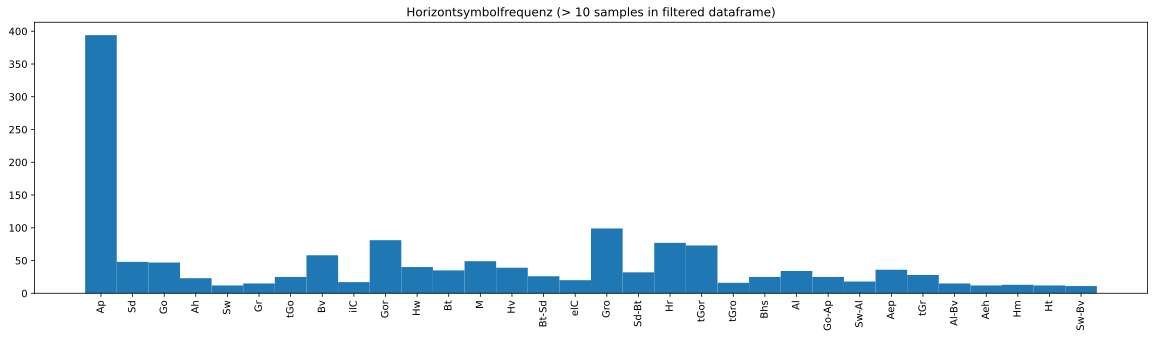

In [21]:
# Filter df to include only rows with labels in keep_horiz_symb
df = df[df[target].isin(keep_horiz_symb)]
print(len(df))

plt.figure(figsize=(20, 5))
plt.hist(df[target], bins=np.arange(len(keep_horiz_symb) + 1) - 0.5, align='mid')
plt.title(f'Horizontsymbolfrequenz (> {samples_thresh} samples in filtered dataframe)')
plt.xticks(ticks=np.arange(len(keep_horiz_symb)), labels=keep_horiz_symb, rotation='vertical')
plt.show()

In [22]:
# Compute the HCEs for the filtered main symbols (without mixtures)
# For this, create a list similar to label_embeddings/main_horizons_parent_child.txt, then run the script compute_class_embeddings.py from semantic-embeddings repo
# After this, load the dictionary of embeddings here and add the embeddings of the mixture labels (see Label_Graph.ipynb)

compute_emb = False
if compute_emb:
    with open('./BGR/label_embeddings/filtered_main_horizons_embeddings.pickle', 'rb') as handle:
        emb_dict = pickle.load(handle)

    # Extend embedding set with mixture labels as linear combinations
    mixture_labs = ['Bt-Sd', 'Sw-Bv', 'Al-Bv', 'Sd-Bt', 'Go-Ap', 'Sw-Al']
    for m_lab in mixture_labs:
        parent1, parent2 = m_lab.split('-')
        if len(parent1) == 1: parent1 += '.' # the main Symbols occuring without suffixes or prefixes are marked with a fullstop
        if len(parent2) == 1: parent2 += '.'
        ind_parent1, ind_parent2 = emb_dict['label2ind'][parent1], emb_dict['label2ind'][parent2]
        # Mean of both parent vectors (can be weighted differently)
        vec_mixture = (emb_dict['embedding'][ind_parent1] + emb_dict['embedding'][ind_parent2]) / 2
        # Add new mixture item to the embedding dict
        emb_dict['ind2label'].append(m_lab)
        emb_dict['label2ind'][m_lab] = len(emb_dict['label2ind'])
        emb_dict['embedding'] = np.vstack([emb_dict['embedding'], vec_mixture])

    # Store new dict extended with mixture embeddings
    with open('./BGR/label_embeddings/filtered_all_horizons_embeddings.pickle', 'wb') as handle:
        pickle.dump(emb_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# If already computed, just load the extended embeddings
with open('./BGR/label_embeddings/filtered_all_horizons_embeddings.pickle', 'rb') as handle:
    emb_dict = pickle.load(handle)
print(np.shape(emb_dict['embedding']))
emb_dict

(32, 26)


{'ind2label': ['Sw',
  'Al',
  'Bv',
  'Bhs',
  'Hr',
  'Aep',
  'Ap',
  'Bt',
  'Gr',
  'Hm',
  'Sd',
  'M.',
  'ilC',
  'tGor',
  'Ah',
  'tGo',
  'Hw',
  'Ht',
  'tGro',
  'Hv',
  'Go',
  'elC',
  'Gor',
  'Aeh',
  'Gro',
  'tGr',
  'Bt-Sd',
  'Sw-Bv',
  'Al-Bv',
  'Sd-Bt',
  'Go-Ap',
  'Sw-Al'],
 'label2ind': {'Sw': 0,
  'Al': 1,
  'Bv': 2,
  'Bhs': 3,
  'Hr': 4,
  'Aep': 5,
  'Ap': 6,
  'Bt': 7,
  'Gr': 8,
  'Hm': 9,
  'Sd': 10,
  'M.': 11,
  'ilC': 12,
  'tGor': 13,
  'Ah': 14,
  'tGo': 15,
  'Hw': 16,
  'Ht': 17,
  'tGro': 18,
  'Hv': 19,
  'Go': 20,
  'elC': 21,
  'Gor': 22,
  'Aeh': 23,
  'Gro': 24,
  'tGr': 25,
  'Bt-Sd': 26,
  'Sw-Bv': 27,
  'Al-Bv': 28,
  'Sd-Bt': 29,
  'Go-Ap': 30,
  'Sw-Al': 31},
 'embedding': array([[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0. 

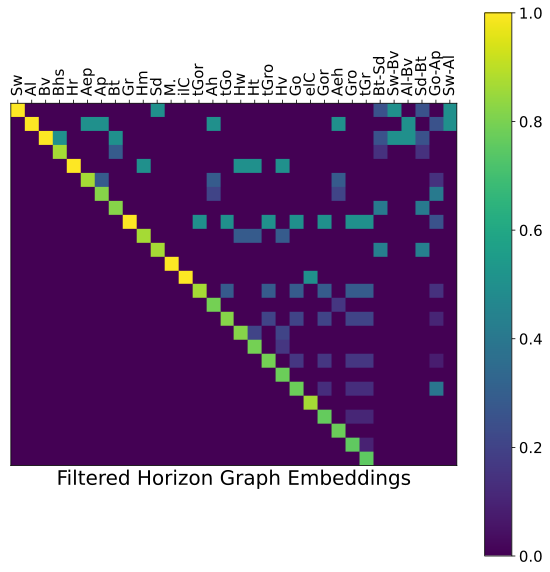

In [24]:
figsize = 10
fontsize = 15
plt.figure(figsize=(figsize,figsize))
plt.imshow(emb_dict['embedding'].T)
plt.xticks(np.arange(len(emb_dict['ind2label'])), emb_dict['ind2label'], rotation=90, fontsize=fontsize)
plt.gca().xaxis.set_ticks_position('top')
plt.xlabel('Filtered Horizon Graph Embeddings', fontsize=fontsize+5)
plt.yticks([])
cbar = plt.colorbar(); cbar.ax.tick_params(labelsize=fontsize)
plt.show()

In [25]:
# Optional: downsample the dominant label
downsample = False
if downsample:
    most_common_label_df = df[df[target] == counts.idxmax()]

    # Randomly sample 100 rows
    sampled_df = most_common_label_df.sample(n=200, random_state=2024)

    # Combine the sampled rows with the rest of the DataFrame
    reduced_df = pd.concat([
        sampled_df,
        df[df['Horizont_cluster'] != counts.idxmax()]
    ])

    # Reset the index (optional)
    df = reduced_df.reset_index(drop=True)
    len(df)

In [26]:
# Encode categorical features
for categ in categ_features:
    bgr_data.encode_categorical_columns(df, categ)
df

/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly ca

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,1.0,0.0,28.0,Ap,0,21,3.0,0,1,2,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,10,0,0,19,127,0,200.0,0.0,0.0,0,0,0,2,0,81.89,54.19
2,2.0,3.0,54.0,68.0,Bv,0,36,10.0,0,2,1,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,10,0,0,19,127,0,200.0,0.0,0.0,0,0,0,2,0,81.89,54.19
4,2.0,5.0,96.0,201.0,ilC,3,30,1.0,0,0,0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,10,0,0,19,127,0,200.0,0.0,0.0,0,0,0,2,0,81.89,54.19
13,4.0,3.0,74.0,140.0,tGro,15,53,0.0,0,0,4,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,8,2018,484922.3074,6080011.471,10,0,0,14,30,2,105.0,0.0,0.0,1,3,0,6,0,65.60,120.40
15,5.0,1.0,0.0,9.0,Aeh,5,11,0.0,0,1,5,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,10,2015,497355.9905,6079646.589,10,1,0,15,131,2,180.0,0.0,0.0,4,2,0,10,5,88.82,220.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160,945.0,5.0,100.0,160.0,elC,15,5,0.0,1,0,0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/BB_09...,10,2016,697632.3426,5884379.93,1,1,0,1,0,0,200.0,0.0,0.0,1,8,0,6,0,106.07,34.64
3161,946.0,1.0,0.0,30.0,Ap,1,13,3.0,0,1,2,80.0,../data/BGR/Profilbilder_no_ruler_no_sky/BB_09...,8,2016,703458.5388,5882791.857,1,0,0,2,1,0,200.0,0.0,0.0,4,2,0,3,0,37.11,23.66
3162,946.0,2.0,30.0,46.0,Al,1,18,2.0,0,2,3,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/BB_09...,8,2016,703458.5388,5882791.857,1,0,0,2,1,0,200.0,0.0,0.0,4,2,0,3,0,37.11,23.66
3164,946.0,4.0,72.0,165.0,Sd,17,60,1.0,0,0,4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/BB_09...,8,2016,703458.5388,5882791.857,1,0,0,2,1,0,200.0,0.0,0.0,4,2,0,3,0,37.11,23.66


In [27]:
# For HCE: create separate dict where labels made out only of main symbols are stripped of the full stop '.'
# Note: We will use the label indexes from the embedding dictionary instead of a new sparse one-hot encoding to ease access to the embedding vectors during training via the original indexes from the emb_dict
dict_mapping = {}
for key, value in emb_dict['label2ind'].items():
    dict_mapping[key.strip('.')] = value
dict_mapping

{'Sw': 0,
 'Al': 1,
 'Bv': 2,
 'Bhs': 3,
 'Hr': 4,
 'Aep': 5,
 'Ap': 6,
 'Bt': 7,
 'Gr': 8,
 'Hm': 9,
 'Sd': 10,
 'M': 11,
 'ilC': 12,
 'tGor': 13,
 'Ah': 14,
 'tGo': 15,
 'Hw': 16,
 'Ht': 17,
 'tGro': 18,
 'Hv': 19,
 'Go': 20,
 'elC': 21,
 'Gor': 22,
 'Aeh': 23,
 'Gro': 24,
 'tGr': 25,
 'Bt-Sd': 26,
 'Sw-Bv': 27,
 'Al-Bv': 28,
 'Sd-Bt': 29,
 'Go-Ap': 30,
 'Sw-Al': 31}

In [30]:
# One-hot encoding of the target column
#bgr_data.encode_categorical_columns(df, target) # for standard one-hot vectors of the targets
df[target] = df[target].map(dict_mapping) # in conjunction with HCEs
df[target] = df[target].astype(int)
df.head(5)

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,1.0,0.0,28.0,6,0,21,3.0,0,1,2,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,10,0,0,19,127,0,200.0,0.0,0.0,0,0,0,2,0,81.89,54.19
2,2.0,3.0,54.0,68.0,2,0,36,10.0,0,2,1,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,10,0,0,19,127,0,200.0,0.0,0.0,0,0,0,2,0,81.89,54.19
4,2.0,5.0,96.0,201.0,12,3,30,1.0,0,0,0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,10,0,0,19,127,0,200.0,0.0,0.0,0,0,0,2,0,81.89,54.19
13,4.0,3.0,74.0,140.0,18,15,53,0.0,0,0,4,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,8,2018,484922.3074,6080011.471,10,0,0,14,30,2,105.0,0.0,0.0,1,3,0,6,0,65.60,120.40
15,5.0,1.0,0.0,9.0,23,5,11,0.0,0,1,5,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,10,2015,497355.9905,6079646.589,10,1,0,15,131,2,180.0,0.0,0.0,4,2,0,10,5,88.82,220.87


### Training

In [29]:
# Define the image normalization
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
])

In [32]:
# Initialize model
vision_backbone = 'WinKawaks/vit-small-patch16-224' # https://huggingface.co/WinKawaks/vit-small-patch16-224/tree/main
#num_classes = len(df[target].unique()) # for one-hot encoding
num_classes = emb_dict['embedding'].shape[1] # for HCE (the dim. of final layer in the model should match the dim of the embedded label vectors)
model = bgr_mod.ImageTabularModel(vision_backbone=vision_backbone,
                                  num_tabular_features=len(feature_columns),
                                  num_classes=num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at WinKawaks/vit-small-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImageTabularModel(
  (vision_backbone): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, 

In [33]:
# Data split
train_df, val_df = train_test_split(df, stratify=df[target], random_state=2024)

print(f'{len(train_df)} samples for training.')
print(f'{len(val_df)} samples for validating.')

1091 samples for training.
364 samples for validating.


In [34]:
# Define the image transforms for augmentation
augment = [
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1., 3.))
]

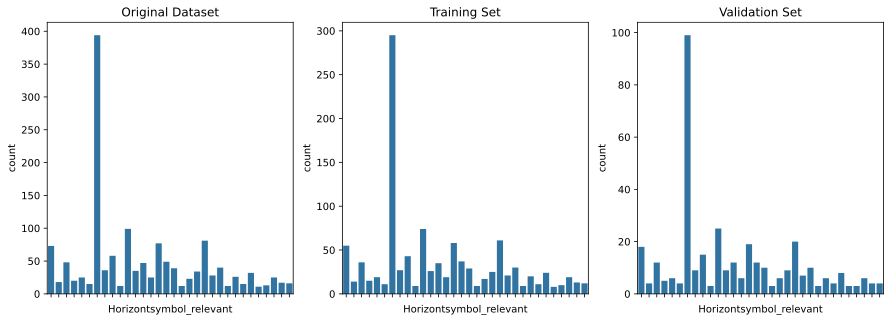

In [35]:
# Visualize the distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(x=target, data=df, ax=axes[0])
axes[0].set_title('Original Dataset'); axes[0].set_xticklabels([])
sns.countplot(x=target, data=train_df, ax=axes[1])
axes[1].set_title('Training Set'); axes[1].set_xticklabels([])
sns.countplot(x=target, data=val_df, ax=axes[2])
axes[2].set_title('Validation Set'); axes[2].set_xticklabels([])
plt.show()

In [36]:
# Create Dataset object with image and tabular features
train_dataset = bgr_data.ImageTabularDataset(dataframe=train_df,#[:100],
                                             normalize=normalize,
                                             augment=augment,
                                             image_path='file',
                                             label=target,
                                             feature_columns=feature_columns)

train_loader = DataLoader(train_dataset, batch_size=64,#16,
                          shuffle=True, num_workers=16)

# Training parameters
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#criterion = nn.CrossEntropyLoss()
#criterion = TopKLoss(k=5)
criterion = nn.CosineEmbeddingLoss() # for HCE: 1 - cos(prediction, target)
# Note: Is MSE better for HCE?

In [37]:
### Callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.1, min_lr=1e-5, verbose=True)
early_stopping = EarlyStopping(patience=10, min_delta=0.01, verbose=True) # looks at val_loss (see callbacks.py)

In [38]:
print(f"Training size original: {len(train_dataset.dataframe)}")
print(f"Training size after augmentation: {len(train_dataset)}")

Training size original: 1091
Training size after augmentation: 3273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0: Tabular Features [406983.46875, 5944784.0, 1.0, 11.0, 2011.0, 200.0, 0.0, 0.0, 76.05000305175781, 42.349998474121094, 7.0, 61.0, 0.0, 5.0, 1.0, 4.0, 0.0, 0.0, 4.0, 234.0, 0.0, 1.0, 6.0, 0.0, 2.0, 0.0] | Label 6
Image 1: Tabular Features [406983.46875, 5944784.0, 1.0, 11.0, 2011.0, 200.0, 0.0, 0.0, 76.05000305175781, 42.349998474121094, 7.0, 61.0, 0.0, 5.0, 1.0, 4.0, 0.0, 0.0, 4.0, 234.0, 0.0, 1.0, 6.0, 0.0, 2.0, 0.0] | Label 6
Image 2: Tabular Features [406983.46875, 5944784.0, 1.0, 11.0, 2011.0, 200.0, 0.0, 0.0, 76.05000305175781, 42.349998474121094, 7.0, 61.0, 0.0, 5.0, 1.0, 4.0, 0.0, 0.0, 4.0, 234.0, 0.0, 1.0, 6.0, 0.0, 2.0, 0.0] | Label 6


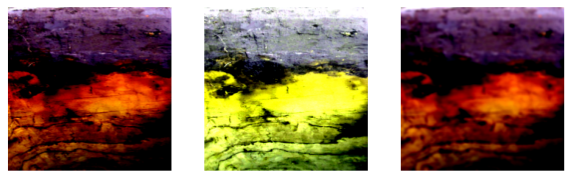

In [39]:
# Check an augmented subset
aug_images = []
for i in range(len(train_dataset)):
    image, tabular_features, label = train_dataset[i]
    aug_images.append(image)
    print(f"Image {i}: Tabular Features {tabular_features.tolist()} | Label {label.item()}")
    if i == 2: break

plt.figure(figsize=(10, 8))
for i in range(len(aug_images)):
    plt.subplot(1, 3, i+1)
    plt.imshow(aug_images[i].swapaxes(0,2).swapaxes(0,1)) # returned shape is (c, h, w)
    plt.axis('off')

In [40]:
val_dataset = bgr_data.ImageTabularDataset(dataframe=val_df,#[:100],
                                           normalize=normalize,
                                           image_path='file',
                                           label=target,
                                           feature_columns=feature_columns)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=16)

In [41]:
model.train()
epochs = 2
lr_history, train_loss_history, val_loss_history = [], [], []
train_acc_history, train_topk_acc_history, val_acc_history, val_topk_acc_history = [], [], [], []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training loop
    train_correct = 0
    train_topk_correct = 0
    train_loss_total = 0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        optimizer.zero_grad() # otherwise, PyTorch accumulates the gradients during backprop
        outputs = model(image=images, tabular_features=tabular_features)

        # Get corresponding embeddings from int-labels
        target_embeddings = torch.stack([torch.tensor(emb_dict['embedding'][lab]) for lab in labels]).to(device)
        # Create a dummy "same class" tensor with 1s for the cosine similarity
        same_class = torch.ones(outputs.size(0)).to(device)
        # Normalize both predictions and target embeddings
        # Note: rather normalize the mixture embeddings immediately after the linear combination of the parents?
        outputs = F.normalize(outputs, p=2, dim=1)
        target_embeddings = F.normalize(target_embeddings, p=2, dim=1)

        #train_loss = criterion(outputs, labels) # for cross entropy or top-k-loss (without HCE)
        train_loss = criterion(outputs, target_embeddings, same_class) # for cosine loss (with HCE)

        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate accuracy for this batch
        train_loss_total += train_loss.item()
        #_, predicted = torch.max(outputs.data, 1)
        #train_correct += (predicted == labels).sum().item()
        #train_topk_correct += top_k_accuracy(outputs, labels, k=5)

        train_loader_tqdm.set_postfix(loss=train_loss.item())

    # Calculate average training accuracy for the epoch
    #train_acc = train_correct / len(train_loader.dataset)
    #train_topk_acc = train_topk_correct / len(train_loader)
    avg_train_loss = train_loss_total / len(train_loader)

    # Evaluation loop
    model.eval()
    val_correct = 0
    val_topk_correct = 0
    val_loss_total = 0
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in val_loader_tqdm:
            images, tabular_features, labels = batch
            images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
            outputs = model(image=images, tabular_features=tabular_features)

            # Get corresponding embeddings from int-labels
            target_embeddings = torch.stack([torch.tensor(emb_dict['embedding'][lab]) for lab in labels]).to(device)
            # Create a dummy "same class" tensor with 1s for the cosine similarity
            same_class = torch.ones(outputs.size(0)).to(device)
            # Normalize both predictions and target embeddings
            # Note: rather normalize the mixture embeddings immediately after the linear combination of the parents?
            outputs = F.normalize(outputs, p=2, dim=1)
            target_embeddings = F.normalize(target_embeddings, p=2, dim=1)

            #val_loss = criterion(outputs, labels) # for cross entropy or top-k-loss (without HCE)
            val_loss = criterion(outputs, target_embeddings, same_class) # for cosine loss (with HCE)

            val_loss_total += val_loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            #val_correct += (predicted == labels).sum().item()
            #val_topk_correct += top_k_accuracy(outputs, labels, k=5)

    # Calculate average val accuracy for the epoch
    #val_acc = val_correct / len(val_loader.dataset)
    #val_topk_acc = val_topk_correct / len(val_loader)
    avg_val_loss = val_loss_total / len(val_loader)

    # Apply the scheduler with validation loss
    scheduler.step(avg_val_loss)
    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    # Log metrics
    train_loss_history.append(avg_train_loss); val_loss_history.append(avg_val_loss)
    #train_acc_history.append(train_acc); val_acc_history.append(val_acc)
    #train_topk_acc_history.append(train_topk_acc); val_topk_acc_history.append(val_topk_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")#, Training Accuracy: {train_acc:.4f}, Training Top {criterion.k} Accuracy: {train_topk_acc:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")#, Validation Accuracy: {val_acc:.4f}, Validation Top {criterion.k} Accuracy: {val_topk_acc:.4f}")
    print(f"Current LR: {current_lr}")

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.should_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/2


Epoch 1, Training Loss: 0.6598
Validation Loss: 0.5762
Current LR: 0.001
Epoch 2/2


Epoch 2, Training Loss: 0.5688
Validation Loss: 0.5406
Current LR: 0.001


### Evaluation

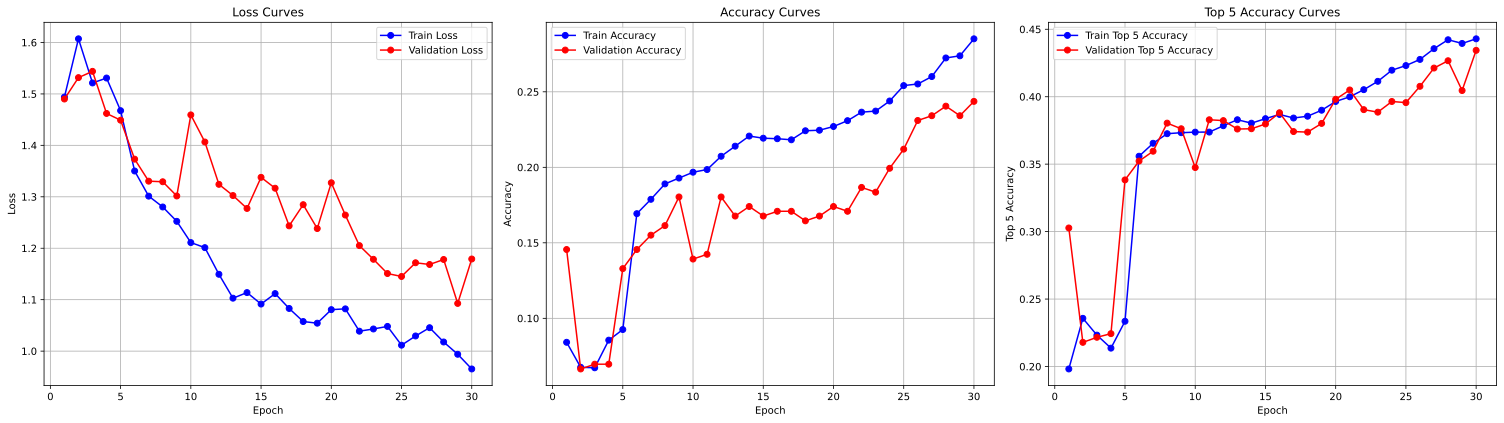

In [46]:
plt.figure(figsize=(21, 6))

complete_epochs = len(train_acc_history)+1
plt.subplot(1, 3, 1)
plt.plot(range(1, complete_epochs), train_loss_history, label='Train Loss', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_loss_history,  label='Validation Loss',  marker='o', color='r')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(range(1, complete_epochs), train_acc_history, label='Train Accuracy', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_acc_history, label='Validation Accuracy', marker='o', color='r')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(range(1, complete_epochs), train_topk_acc_history, label=f'Train Top {criterion.k} Accuracy', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_topk_acc_history, label=f'Validation Top {criterion.k} Accuracy', marker='o', color='r')
plt.title(f'Top {criterion.k} Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel(f'Top {criterion.k} Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

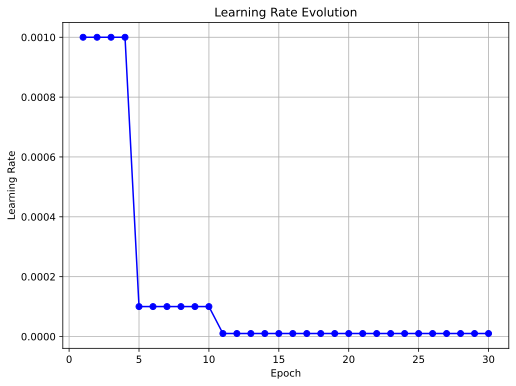

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, complete_epochs), lr_history, marker='o', linestyle='-', color='b')
plt.title("Learning Rate Evolution")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid()
plt.show()

In [48]:
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    outputs = []
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    for batch in val_loader_tqdm:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        outputs.append(model(image=images, tabular_features=tabular_features))

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert outputs to predicted labels (adjust based on your model's output format)
predicted_probs, predicted_labels = [], []
for output in outputs:

    predicted_labels.extend(torch.argmax(output, dim=1).tolist())
    predicted_probs.extend(torch.softmax(output, dim=1).cpu().numpy()) # Convert logits to probabilities

# Convert true labels to a list
true_labels = [label.item() for batch in val_loader for label in batch[2]]

# Calculate metrics
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.15      0.42      0.23        50
           1       0.13      0.27      0.17        30
           2       0.06      0.09      0.07        22
           3       0.07      0.19      0.11        21
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         7
          16       0.00      0.00      0.00         6
          17       0.00    

/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [50]:
# Compute PR curve for each class
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

predicted_probs = np.array(predicted_probs)
true_labels = np.array(true_labels)
n_classes = predicted_probs.shape[1]
precision, recall, avg_precision = {}, {}, {}
# Binarize the labels (one-hot encoding for multiclass)
true_labels_binarized = label_binarize(true_labels, classes=np.arange(n_classes))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_binarized[:, i], predicted_probs[:, i])
    avg_precision[i] = average_precision_score(true_labels_binarized[:, i], predicted_probs[:, i])

# Compute macro-average PR curve
precision["macro"], recall["macro"], _ = precision_recall_curve(true_labels_binarized.ravel(), predicted_probs.ravel())
avg_precision["macro"] = average_precision_score(true_labels_binarized, predicted_probs, average="macro")

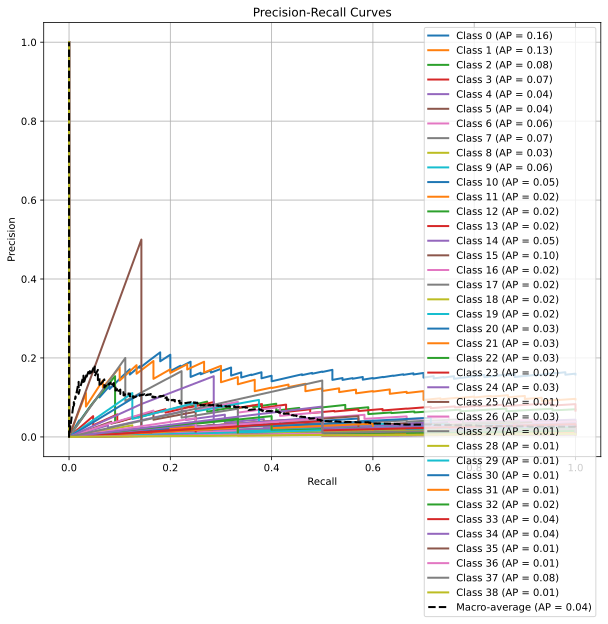

In [51]:
plt.figure(figsize=(10, 8))

# Plot PR curves for each class
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {avg_precision[i]:.2f})')

# Plot macro-average PR curve
plt.plot(recall["macro"], precision["macro"], linestyle='--', lw=2, color='black',
         label=f'Macro-average (AP = {avg_precision["macro"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid()
plt.show()

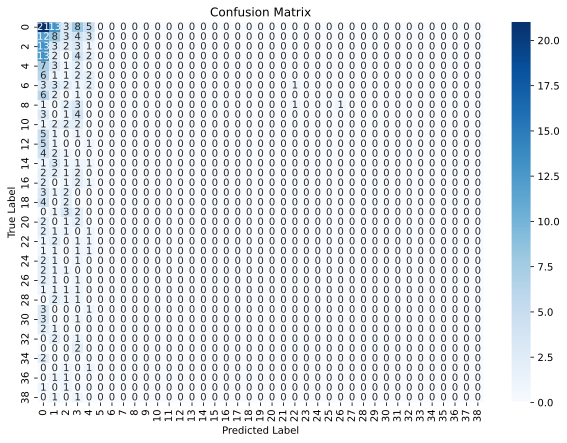

In [52]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [53]:
"""
# TODO
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./testtest",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    num_train_epochs=53,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=1000,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",  # Set to "wandb" or other service if tracking experiments
)

# Initialize the Trainer with the model, data, and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']}")
"""

'\n# TODO\nfrom transformers import TrainingArguments, Trainer\n\n# Define training arguments\ntraining_args = TrainingArguments(\n    output_dir="./testtest",\n    per_device_train_batch_size=32,\n    per_device_eval_batch_size=32,\n    evaluation_strategy="epoch",\n    num_train_epochs=53,\n    logging_dir="./logs",\n    logging_steps=10,\n    save_steps=1000,\n    learning_rate=5e-5,\n    weight_decay=0.01,\n    report_to="none",  # Set to "wandb" or other service if tracking experiments\n)\n\n# Initialize the Trainer with the model, data, and training arguments\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataset,\n    eval_dataset=test_dataset,\n    data_collator=collate_fn,\n)\n\n# Train the model\ntrainer.train()\n\n# Evaluate the model on the test dataset\neval_results = trainer.evaluate()\nprint(f"Test Accuracy: {eval_results[\'eval_accuracy\']}")\n'